In [9]:
# Load libraries
from sklearn.preprocessing import StandardScaler
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

# Set random seed
np.random.seed(42)

In [ ]:
# file locations
data_file = 'procedure/data/snapshots/'

In [11]:
### Helpful functions
def min_impute(dataframe, axis=0):
    """Fills NaN with the axis median.
    Args:
        df (pandas.DataFrame): a vectorized dataframe
        axis (Optional[int]): by rows(1) or columns(0), Default=1
    Returns:
        pandas.DataFrame: a copy of the provided dataframe with the
            null values filled with axis median.
    """

    return dataframe.apply(lambda x: x.fillna(x.min()), axis=axis)


def report_na(df, axis=0, perc=True):
    """Reports on the `NaN`s of a vectorized dataframe
    :func:`DataInterface.get_data(vectorize = True)
            <analytics.data.datainterface.DataInterface.get_data>`
    Args:
        df (pandas.DataFrame): a vectorized dataframe
        axis (int): count by rows(1) or columns(0)
        perc (bool): return as percentage[Default: True] or count
    Returns:
        pandas.Series: the count or percent of NaNs for the given axis
    Notes:
        An example of how one might look at this result is:
        >>> import seaborn as sns
        >>> import matplotlib.pyplot as plt
        >>> sns.countplot(report_na(chemd['real'], axis=0))
        >>> plt.xticks(rotation=25)
    """
    if perc:
        return df.apply(lambda x: sum(x.isnull())/float(len(x)), axis=axis)
    else:
        return df.apply(lambda x: sum(x.isnull()), axis=axis)

def clean_NAs(df, percentage=0.10):
    # Keep labs with low percentage of NAs
    col_perc = report_na(df, axis=0)
    keep_labs = col_perc[col_perc <= percentage].index
    df_keep = df[keep_labs]

    # Keep patients with most values not na
    row_perc = report_na(df, axis=1)
    keep_labs = row_perc[row_perc <= percentage].index
    df_labs = df_keep.loc[keep_labs]
    return(df_keep)

def drop_scale(df):
    # Drop columns froma  list of column names
    id = "public_client_id"
    df = df.drop(["sample_id", "days_in_program", "days_since_first_call", "days_since_first_draw", "month", "weekday", "season", "Chip_ID_CVD2", "Chip_ID_CVD3", "Chip_ID_INF", "vendor", "vendor_observation_id",	"observation_id", "reflexive", "fasting"], axis=1, errors='ignore')
    other_cols = df.columns.difference([id])
    df = min_impute(df.set_index('public_client_id'))
    #df[other_cols] = df[other_cols].apply(stats.zscore, nan_policy="omit")
    return(df)
    


# run_LASSO_model() function takes as input a dataframe with all the features and the outcome variable (df),
# the name of the outcome variable(outcome), 
# the number of cross-validations (CV) you want to perform,
# as well as the eps parameter that specifies the search space for the penalty parameter alpha in the LASSO objective function

#The function then returns 4 values: 
    #1)the out-of-sample r2 for each fold (list)
    #2)out-of-sample predictions for each individual (liist)
    #3)The beta-coefficient for each metabolite in each of the models (df)
    #4)the L1 regularization parameter for each model (list)
    
def run_LASSO_model(df,outcome,CV=10,eps=0.1):
    #specify feature table excluding the outcome variable
    X = df.loc[:, df.columns!=outcome]
    #scale and standardize the feature table
    scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
    Xcolumns=X.columns
    X = scaler.fit_transform(X)
    X=pd.DataFrame(data=X,columns=Xcolumns)
    print('feature table shape',X.shape)
    print('outcome variable=',outcome, 'CV=',CV,'eps=',eps)
    y=df[outcome]
    ind=y.index.name
    y=y.reset_index()
    y.drop([ind],axis=1,inplace=True)
    #split data into CV folds
    X_folds = np.array_split(X, CV)
    y_folds = np.array_split(y, CV)
    coefficients=pd.DataFrame(index=X.columns).astype('float64')
    predictions=[]
    alphas= []
    score= []
    #run LASSO using the scikit-Learn LASSOCV function
    lassocv=LassoCV(eps=eps, n_alphas=200, alphas=None, fit_intercept=True, precompute='auto', cv=CV)
    print('starting cross-validation procedure...')
    for k in range(CV):
        X_train = list(X_folds)
        X_test  = X_train.pop(k)
        X_train = np.concatenate(X_train)
        y_train = list(y_folds)
        y_test  = y_train.pop(k)
        y_test=[ x[0] for x in  list(y_test.values)]
        y_train = np.concatenate(y_train)
        lassocv.fit(X_train, y_train)
        predictions.append(lassocv.predict(X_test).flatten())
        coef=list(lassocv.coef_)
        coefficients[k]=coef
        alphas.append(lassocv.alpha_)
        r2=r2_score(y_test,lassocv.predict(X_test))
        score.append(r2)
        print('CV-fold {},test set r2={}'.format(k+1,round(r2,3)))
    predictions_lasso=[item for sublist in predictions for item in sublist]
    print('Done!')
    return score,predictions_lasso,coefficients,alphas

In [12]:
# Load the data and the participants

# add the data location to the file names
participants = pd.read_csv(data_file + "clients.tsv", skiprows=13, sep='\t', converters={'public_client_id': str})
participants = participants[["public_client_id", "sex", "age"]]

mets = pd.read_csv(data_file + "metabolomics_corrected.tsv", skiprows=13, sep='\t', converters={'public_client_id': str})
chem = pd.read_csv(data_file + "chemistries.tsv", skiprows=13, sep='\t', converters={'public_client_id': str})

div = pd.read_csv(data_file + "microbiome_trimmed_diversity.tsv", skiprows=13, sep='\t', converters={'public_client_id': str})


In [13]:
mets_meta = pd.read_csv(data_file + "metabolomics_metadata.tsv", skiprows=13, sep='\t')

mets_meta.index = map(str, mets_meta['CHEMICAL_ID'])
mets.columns = [x if x not in mets_meta.index else "%s" % (mets_meta.loc[x, 'BIOCHEMICAL_NAME']) for x in mets.columns]

mets_drop = mets.columns[mets.columns.str.startswith('X -')]
mets.drop(mets_drop, axis=1, inplace=True)
mets.shape

(3225, 1036)

In [14]:
# Get a list of Lipids from Super_Pathways columns in mets meta
lipids = mets_meta.loc[mets_meta['SUPER_PATHWAY'] == 'Lipid', 'BIOCHEMICAL_NAME'].tolist()
mets.drop(lipids , axis=1, inplace=True)
mets.shape

(3225, 565)

In [15]:
mets = mets.sort_values('days_since_first_draw').groupby('public_client_id').first().reset_index()
mets_clean = clean_NAs(mets, percentage=0.15)
mets_impute = drop_scale(mets_clean)

print(mets_impute.shape)
# Log transform the data
mets_impute = np.log2(mets_impute)

(2001, 361)


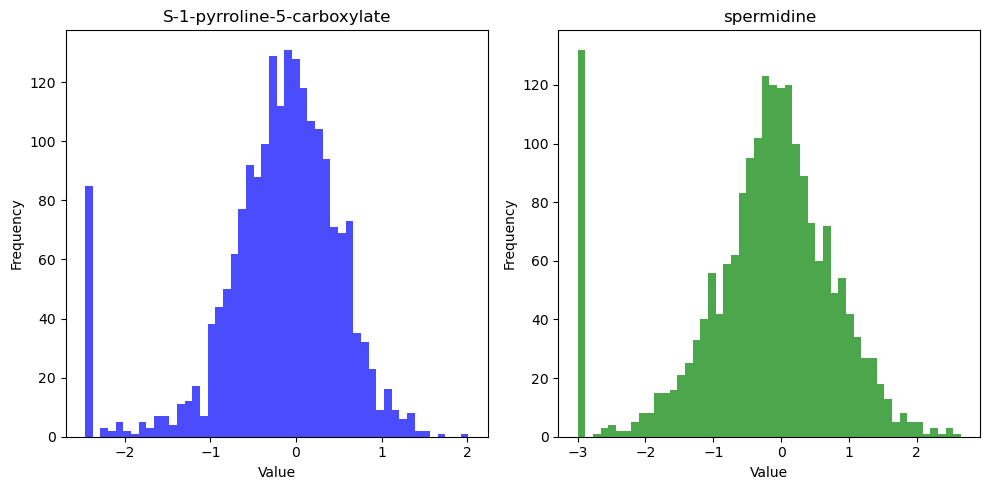

In [16]:
# histogram of S-1-pyrroline-5-carboxylate and spermidine
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.hist(mets_impute['S-1-pyrroline-5-carboxylate'], bins=50, color='blue', alpha=0.7)
plt.title('S-1-pyrroline-5-carboxylate')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.subplot(1, 2, 2)
plt.hist(mets_impute['spermidine'], bins=50, color='green', alpha=0.7)
plt.title('spermidine')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


In [17]:
div = div.sort_values('days_since_first_draw').groupby('public_client_id').first().reset_index()
# Filter days since first draw is less than absolute value of 21 days
div = div[div['days_since_first_draw'] < 21]
div = div[div['days_since_first_draw'] > -21]
div_clean = clean_NAs(div, percentage=0.15)


In [18]:
# keep public_client_id and diversity_shannon
div_clean = div_clean[['public_client_id', 'diversity_shannon']]


In [19]:
# merge the dataframes on public_client_id
mets_div = pd.merge(mets_impute, div_clean, on='public_client_id', how='inner')
# set the index to public_client_id
mets_div.set_index('public_client_id', inplace=True)

mets_div

,S-1-pyrroline-5-carboxylate,spermidine,1-methylnicotinamide,alpha-ketoglutarate,kynurenate,3-hydroxyisobutyrate,3-phosphoglycerate,"5,6-dihydrothymine",hypoxanthine,quinolinate,...,2-ketocaprylate,"2,3-dihydroxy-5-methylthio-4-pentenoate (DMTPA)*","hydroxy-N6,N6,N6-trimethyllysine*","3,5-dichloro-2,6-dihydroxybenzoic acid",(S)-a-amino-omega-caprolactam,"branched-chain, straight-chain, or cyclopropyl 10:1 fatty acid (1)*","3-bromo-5-chloro-2,6-dihydroxybenzoic acid*","branched-chain, straight-chain, or cyclopropyl 12:1 fatty acid*",4-chlorobenzoic acid,diversity_shannon
public_client_id,,,,,,,,,,,,,,,,,,,,,
01000261,-0.033226,1.364433,0.196023,-0.058596,-0.377047,-0.476583,2.414323,0.367010,0.183379,-0.689308,...,0.603200,-0.071773,0.049549,-0.480865,0.020316,-0.130848,-0.359474,0.252816,0.126359,4.313455
01002183,-0.911778,1.180072,-1.247050,-0.214416,0.791767,-2.036552,1.903033,0.072650,0.544871,0.592276,...,-0.348462,0.158783,0.365360,-0.165333,-0.085515,2.108466,0.172768,1.269355,0.089149,4.301671
01002412,-0.204897,-0.898252,-0.000723,-0.170052,-0.378137,0.076935,0.340889,-0.132977,0.455974,0.240446,...,0.694573,0.021854,0.173008,-0.181510,0.149766,1.360478,-0.347766,0.954492,0.099100,4.515161
01003114,0.555616,0.737787,0.587196,-0.102010,-0.130869,-1.250423,1.194957,-0.000857,-0.873993,0.289601,...,-0.180927,-0.082110,0.293468,-1.154106,0.029160,-1.076156,-1.038838,-0.361126,-0.109130,4.210869
01003555,-0.479456,-0.153250,-0.046882,0.993199,0.484366,-0.171085,0.495890,0.442431,0.020673,0.110218,...,0.334925,0.409740,1.241402,0.015437,0.237987,-0.751656,-0.269426,-0.764163,0.022890,3.853898
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
01997759,-2.461814,-3.000829,0.040044,-0.022277,0.159544,-0.791589,-2.538390,0.389403,0.519196,0.350241,...,-0.087083,0.584422,-0.211719,1.564340,-0.143266,0.716466,0.223946,0.216226,0.009806,4.436835
01997909,-0.165016,0.229018,0.325918,-0.103103,0.492824,-1.046879,0.332144,0.578103,0.178943,0.401674,...,0.855977,0.263682,0.018665,-0.438040,0.018189,0.057706,-0.338061,-0.711976,-0.379575,4.583089
01998999,0.584149,0.119847,-0.236855,-0.317823,0.150067,-0.332057,-1.366326,-0.211622,-0.789351,-0.037273,...,1.282745,0.597017,-0.240122,-0.461580,-0.023754,1.028134,-0.579841,0.517897,-0.155663,4.072933


In [74]:
#run a 10-fold CV implementation of LASSO to predict gut alpha diversity(shannon diversity)
results=run_LASSO_model(mets_div, outcome='diversity_shannon',eps=0.175)

feature table shape (1449, 361)
outcome variable= diversity_shannon CV= 10 eps= 0.175
starting cross-validation procedure...
CV-fold 1,test set r2=0.257
CV-fold 2,test set r2=0.365
CV-fold 3,test set r2=0.285
CV-fold 4,test set r2=0.336
CV-fold 5,test set r2=0.375
CV-fold 6,test set r2=0.334
CV-fold 7,test set r2=0.337
CV-fold 8,test set r2=0.399
CV-fold 9,test set r2=0.363
CV-fold 10,test set r2=0.406
Done!


In [77]:
#evaluating  model performance across the 10-fold CV:
print('mean out-of-sample R2(std.dev)={}({})'.format(round(np.mean(results[0]),3),round(np.std(results[0]),3)))
corr=stats.spearmanr(results[1], mets_div['diversity_shannon'])
print('correlation of predicted versus observed values,Spearman rho={},p-value={}'.format(round(corr[0],3),corr[1]))

mean out-of-sample R2(std.dev)=0.346(0.045)
correlation of predicted versus observed values,Spearman rho=0.588,p-value=2.918480615267448e-135


In [78]:
#exploring top features: a function that takes the output of run_LASSO_model() and identifies features with non-zero Beta-coefficients
#in at least one of the LASSO models generated. It also calculates basic statitistics for each beta-coefficient
def feature_extraction(model_results=results):
    feat=model_results[2].copy()
    print('total no. of features trained on={}'.format(feat.shape[0]))
    #drop all metabolites that were not retained by at least one LASSO model
    for x in feat.index.tolist():
        if (feat.loc[x] == 0.0).sum()==len(feat.columns):
            feat.drop([x],inplace=True)   
    #calculate the mean, std, and number of models in which the metabolites was not retained
    means=[]
    std=[]
    zeroes=[]
    for x in feat.index.tolist():
        means.append((np.mean(feat.loc[x])))
        std.append((np.std(feat.loc[x])))
        zeroes.append((feat.loc[x] == 0.0).astype(int).sum())
    feat['mean']=means
    feat['std_dev']=std
    feat['zeroes']=zeroes
    print('total no. features retained in at least one model={}'.format(feat.shape[0]))
    print ('total no. of features retained by all {} models={}'.format(results[2].shape[1],feat[feat['zeroes']==0].shape[0]))
    #return a new df containing only features retained by at least one LASSO model
    return feat

In [79]:

#identify top features from our metabolomics models
met_features=feature_extraction(results)

total no. of features trained on=361
total no. features retained in at least one model=31
total no. of features retained by all 10 models=17


In [85]:
met_features
# write the features to a file
met_features.to_csv('met_features.csv', sep=',', index=True, header=True)

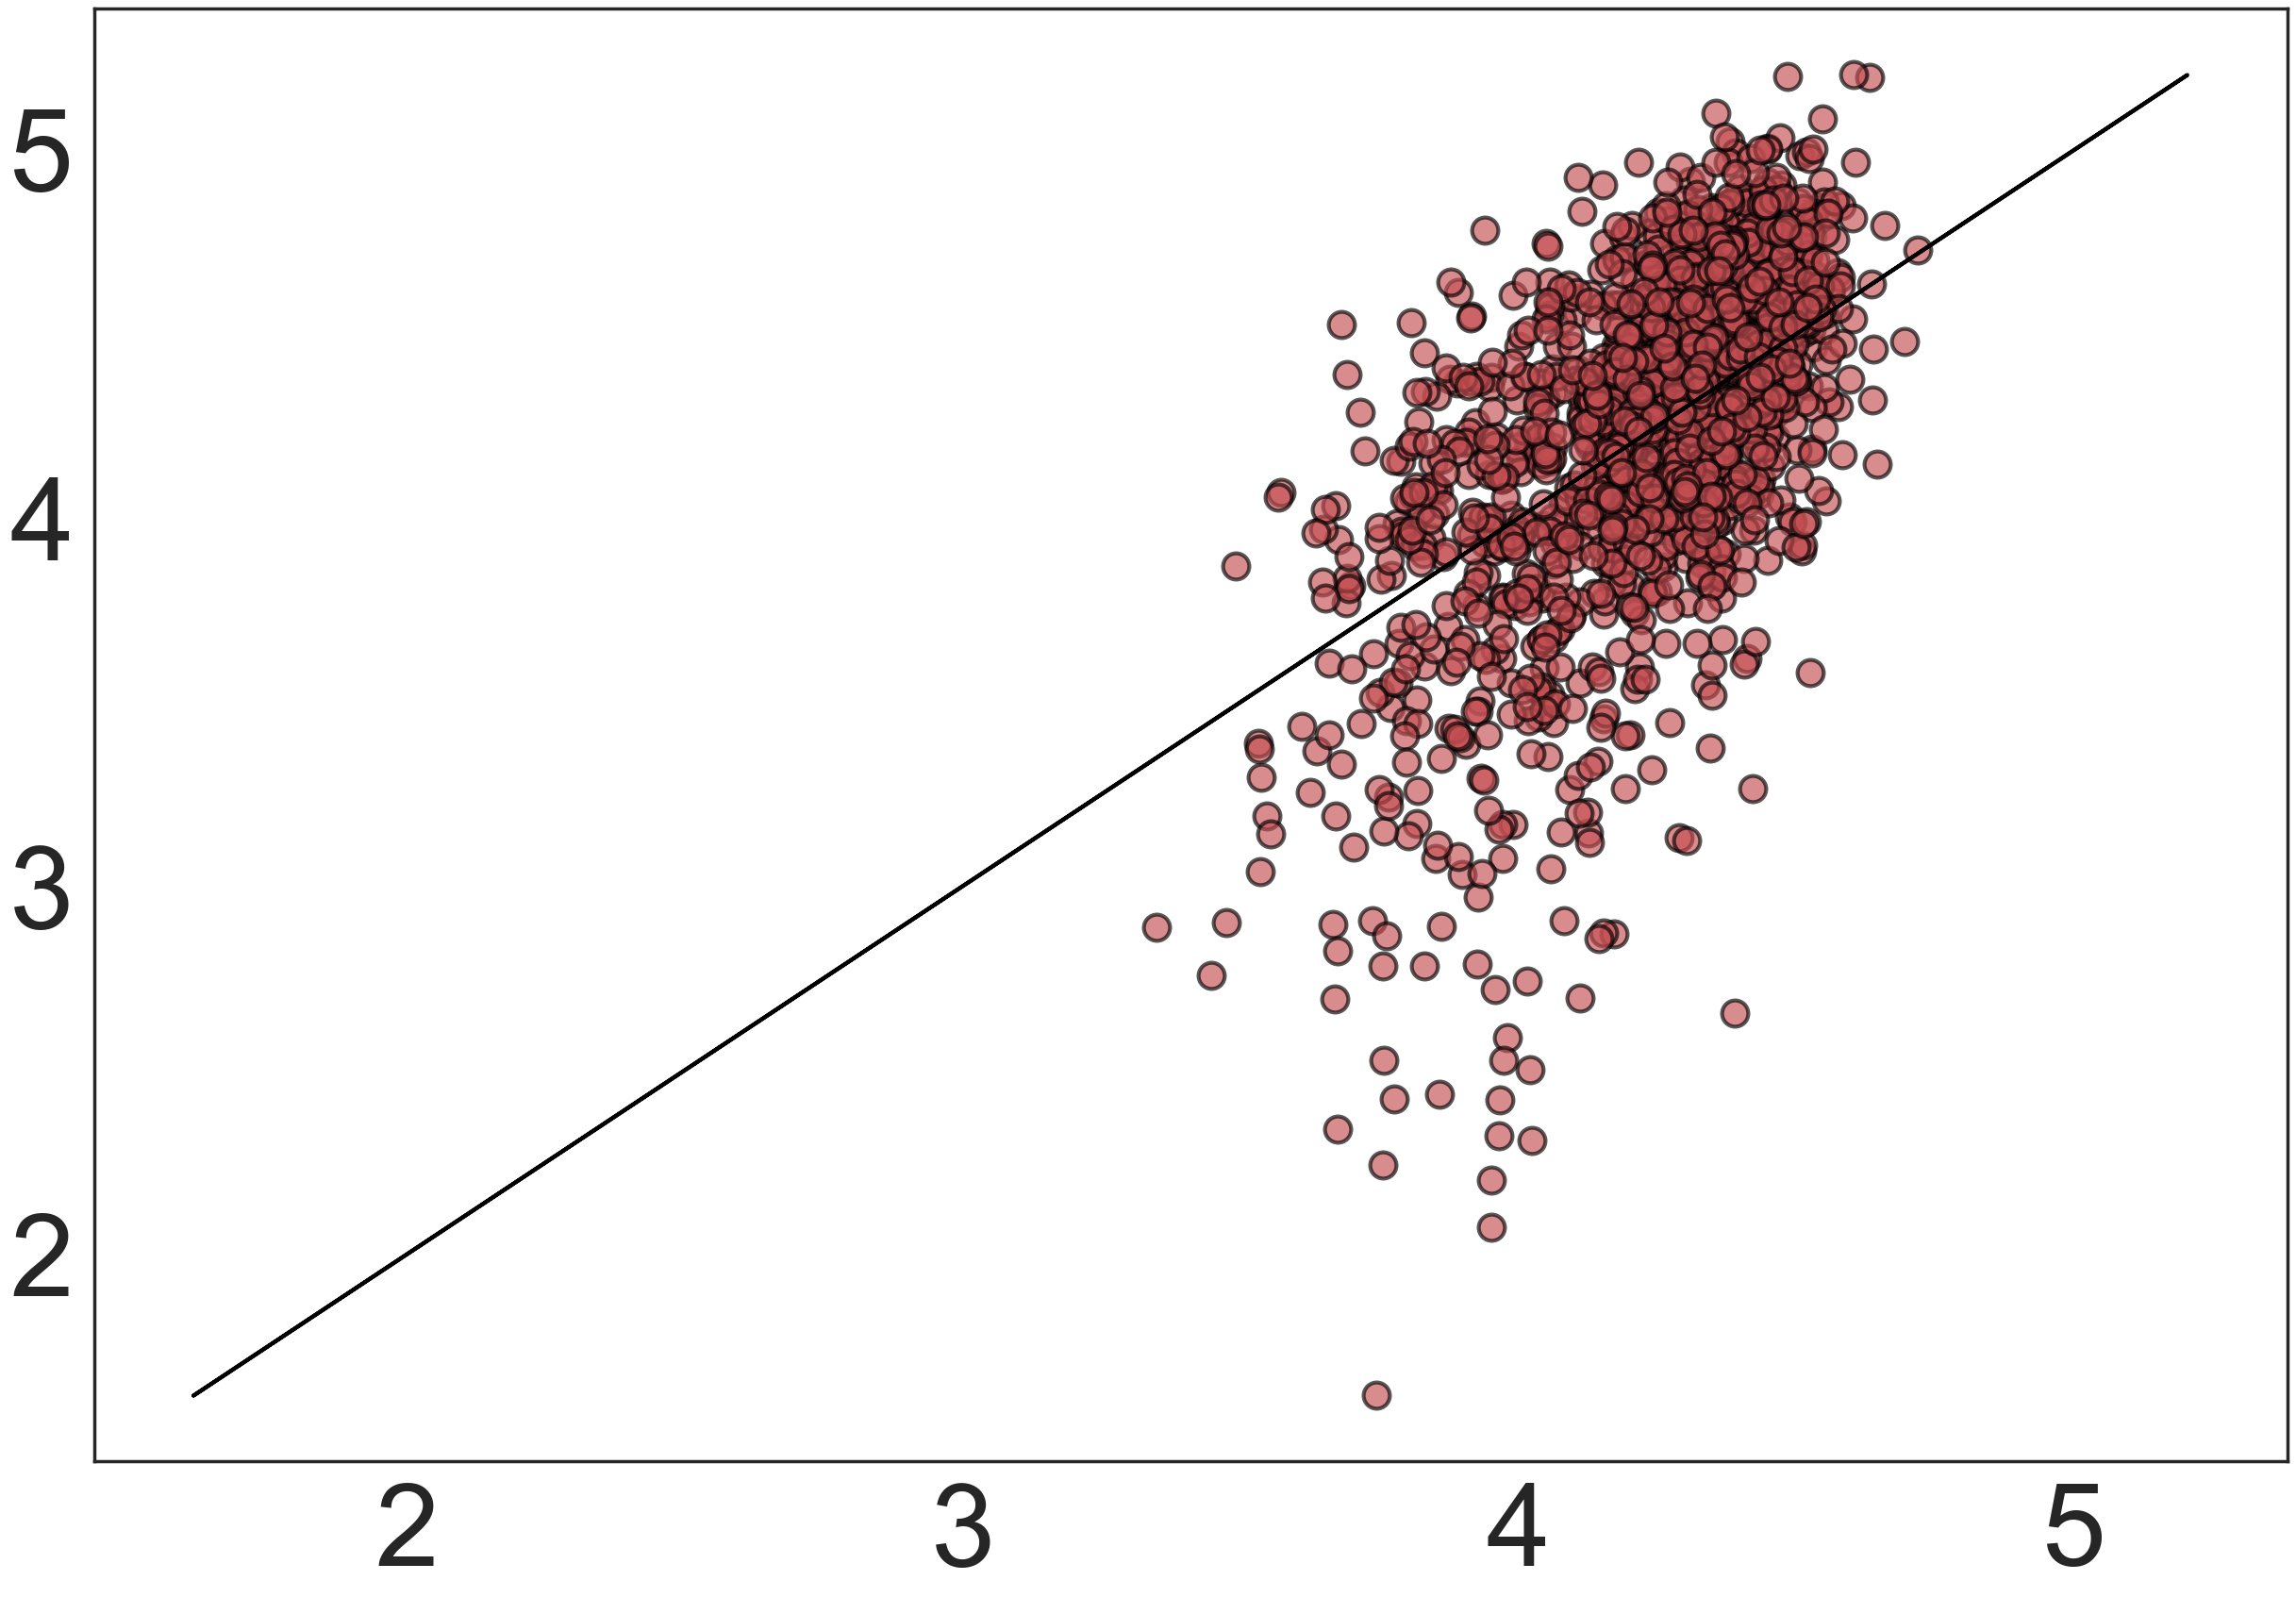

In [86]:
#how do our out-of-sample predictions compare to observed values
sns.set(font_scale=4.00,context='poster',font='Arial',style='white')
plt.figure(figsize=[30,20], dpi=100)
plt.scatter(results[1], mets_div['diversity_shannon'],s=400,color='r',alpha=0.65,linewidth=3,edgecolors='black')
plt.plot(mets_div['diversity_shannon'],mets_div['diversity_shannon'],color='black')
plt.show()

In [89]:
#How about collinearity among the predictor variables? LASSO should select mostly orthogonal features
#but let's see if that is the case by generating a correlation heatmap

#Select only the mets retained by LASSO for correlation
corr_df=pd.DataFrame(index=mets_div.index)
for x in met_features.index.tolist():
    corr_df[x]=mets_div[x]
#Change metabolite names to just the name (no family, subfamily)
corr_df.columns=list([x.split(":")[0].split(".")[-1] for x in corr_df.columns.tolist()])
# Compute the correlation matrix
corr = corr_df.corr('spearman')
# Generate a mask for the upper triangle
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
sns.set(font_scale=0.25,context='poster',font='Arial',style='white')
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(250, 40, as_cmap=True)
heatmap=sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
heatmap
plt.savefig('heatmap_40_.png',dpi=200)

In [21]:
# Load the met_features.csv file
met_features = pd.read_csv('met_features.csv', index_col=0)
# Filter the features to include 
# only those with only 0 zeroes (i.e., retained in all models)
met_features_all = met_features[met_features['zeroes'] == 0]


In [22]:
# Filter the original mets_div dataframe to include only the features in met_features_all plus shannon diversity
mets_div_all = mets_div[met_features_all.index.tolist() + ['diversity_shannon']]
mets_div_all

,glutarate (C5-DC),maltose,3-phenylpropionate (hydrocinnamate),hippurate,ribitol,cysteine s-sulfate,threonate,indolepropionate,p-cresol sulfate,4-ethylphenylsulfate,cinnamoylglycine,1-methyl-5-imidazoleacetate,imidazole propionate,3-hydroxypyridine sulfate,"diacylglycerol (16:1/18:2 [2], 16:0/18:3 [1])*",perfluorooctanesulfonate (PFOS),1-carboxyethylphenylalanine,diversity_shannon
public_client_id,,,,,,,,,,,,,,,,,,
01000261,-0.158374,0.474479,1.461297,1.441465,0.142628,1.898704,0.719760,2.354460,-0.080481,-0.874077,1.091432,-1.572887,-0.100496,0.278302,0.342510,0.484596,0.819025,4.313455
01002183,0.727266,-0.011018,-0.026665,0.379797,-0.039835,2.549043,0.311199,-1.070887,-0.219306,-1.808715,5.762229,-0.704048,-0.137248,0.501649,-0.395585,1.473929,-0.137646,4.301671
01002412,-0.483232,-4.718394,0.253781,-0.150910,0.064484,2.106048,0.567897,-0.743647,0.395116,-0.199457,0.967638,0.615199,-0.654191,-0.565880,2.162942,1.977624,-0.406606,4.515161
01003114,-0.870907,2.250513,0.897581,-0.003842,0.229186,-0.568229,-0.192463,-0.494737,-0.009274,0.087491,0.040745,1.099330,-0.220698,-0.110215,0.655985,0.381304,-0.240398,4.210869
01003555,0.471094,1.660390,1.123731,1.010144,0.360755,0.736347,0.378661,0.408935,0.015025,0.212888,0.946730,-0.312447,1.431206,2.961514,0.760504,-1.296899,0.454790,3.853898
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
01997759,0.797008,-1.329517,-1.263399,-1.084374,0.623417,0.142880,-0.945105,-0.093463,0.843383,1.919204,-0.683956,-0.662989,0.051533,0.159915,-1.072707,-0.245377,0.482860,4.436835
01997909,-0.753455,-1.350607,-5.213119,0.357192,-0.080590,2.072520,0.159364,2.166007,-1.041675,-0.330155,-0.266281,0.335681,0.247446,0.800836,-0.498170,0.266392,-0.169692,4.583089
01998999,-0.303356,-2.171644,0.783749,1.405251,0.250192,0.521343,0.017064,0.957621,-1.313493,1.340078,0.639106,-0.089955,0.648424,-1.302475,0.591515,-0.614711,0.963611,4.072933


In [24]:
# Run 10-fold CV regression on the filtered dataset to get r2 and predictions
results_all = run_LASSO_model(mets_div_all, outcome='diversity_shannon', eps=0.075)
# Evaluate model performance across the 10-fold CV
print('mean out-of-sample R2(std.dev)={}({})'.format(round(np.mean(results_all[0]),3),round(np.std(results_all[0]),3)))

feature table shape (1449, 17)
outcome variable= diversity_shannon CV= 10 eps= 0.075
starting cross-validation procedure...
CV-fold 1,test set r2=0.312
CV-fold 2,test set r2=0.352
CV-fold 3,test set r2=0.318
CV-fold 4,test set r2=0.411
CV-fold 5,test set r2=0.451
CV-fold 6,test set r2=0.387
CV-fold 7,test set r2=0.418
CV-fold 8,test set r2=0.483
CV-fold 9,test set r2=0.42
CV-fold 10,test set r2=0.411
Done!
mean out-of-sample R2(std.dev)=0.396(0.052)


R2 score for OLS regression on test set:  0.33195731953952656


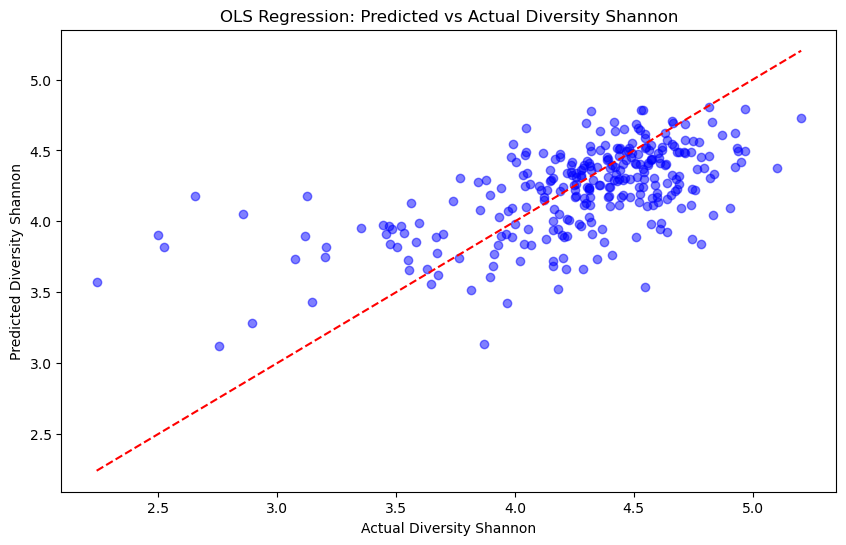

In [27]:
# split into training and test sets of 80 20 and run a ols regression model using the features retained in all models
from sklearn.linear_model import LinearRegression


X_train, X_test, y_train, y_test = train_test_split(mets_div_all.drop(columns=['diversity_shannon']), 
                                                    mets_div_all['diversity_shannon'], 
                                                    test_size=0.2, random_state=42)
# Fit the OLS model
ols = LinearRegression()
ols.fit(X_train, y_train)
# Make predictions on the test set
y_pred = ols.predict(X_test)
# Calculate the R2 score
r2 = r2_score(y_test, y_pred)
print('R2 score for OLS regression on test set: ', r2)
# Plot the predicted vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.xlabel('Actual Diversity Shannon')
plt.ylabel('Predicted Diversity Shannon')
plt.title('OLS Regression: Predicted vs Actual Diversity Shannon')
plt.show()

